# <u>Vector-Quantized VAE (VQ-VAE)</u>
From "Neural Discrete Representation Learning", by Aäron van den Oord et al.

## Introduction
VAEs can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or separating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

## Main Difference = Latent Space

![](fig/vqvae.png)
![](https://drive.google.com/uc?export=view&id=1t96Cgxz5RLWazJP9irB70rY5-zHodImQ)

## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, C]` where `K` are the number of embeddings and `C` is the dimensionality of each latent embedding vector, i.e. $e_i \in \mathbb{R}^{C}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More precisely, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output where we make sure the channels $C$ are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output its index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `C` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from six.moves import xrange
import umap.umap_ as umap

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

C:\Users\miker\anaconda3\envs\hy673\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Load Data

In [ ]:
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))])
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transf)
validation_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transf)
data_variance = np.var(training_data.data / 255.0)

Files already downloaded and verified
Files already downloaded and verified


# <u>Vector Quantizer</u>
1) Ignoring the batch size for now, as a first step we reshape and flatten the input: (C,H,W) -> (H,W,C) -> (H*W,C), where CHW = Channels, Height, Width.

2) Then we will calculate the Euclidean distance between each input vector (H*W in total of dimension C) and the embedding vectors $e_i \in \mathbb{R}^C, \ i = 1,2,\dots,K$, to determine the indices of the closest embeddings for each input vector. If $z_i$ is the $i$-th vector to be quantized, then its quantized version $\text{Quantize}(z_i)$ will be the embedding $e_k$ that has the closest distance to $z_i$:
\begin{equation}
    \text{Quantize}(z_i) = e_k, \ \text{where} \ k = \text{arg} \min_j || z_i - e_j ||_2.
\end{equation}
3) In code, the one-hot encoded matrix `encodings` (1 for k = argmin and 0 otherwise) represents these indices. Using them we select the embeddings that correspond to the closest vectors for each input.

4) Then we unflatten and reshape back to the shape before flattening: (H*W,C) -> (H,W,C) and calculate two losses:

5) **e-latent loss:** MSE between the **detached** quantized vectors and the inputs. By detaching the quantized vectors, gradients are not backpropagated through to train the embedding layer, but only the encoder, encouraging it to produce outputs closer to the embeddings in the codebook.

6) **q-latent loss:** MSE between the quantized vectors and the **detached** inputs. Detaching the inputs prevents gradients from flowing into the encoder, thus directing the optimization to adjust the codebook vectors to better match the encoder's outputs. So, this is like a mirrored version of the previous loss: it trains the embedding layer and not the encoder.

7) **Total loss:** Is just the combination of the two, with the `commitment_cost` scaling the e_latent_loss.

8) Another important step is to adjust the output to ensure gradient flow. We do this by adding the difference between the inputs and the quantized vectors (detached) back to the inputs. This is called **straight through estimation**. A more intuitive explanation of why this works: Say $f$ is a non-differentiable function, and we want to do the operation $B = f(A)$, but backpropagation cannot compute the gradient of $f$. What we can do, however, is: $B = A + (f(A) - A)\text{.detach()}$, a.k.a. the straight-through estimator. This effectively makes the gradient skip the quantization part (red arrow in the VQ-VAE picture above).  Note: we cannot just do $B = f(A)\text{.detach()}$ because that would stop all gradients at the quantized values.

9) **Perplexity metric:** VQ-VAEs come with their own set of challenges, an important being **codebook collapse**. It refers to the scenario where many of the embedding vectors become unused or underused, leading to a situation where the model relies on a limites set of embeddings to represent the data, thus reducing the diversity and possibly quality of the generated outputs. Hence, we need a way to monitor the codebook's usage, and that is where **perplexity** comes into play. It measures the diversity of the used embeddings by calculating the perplexity of the average usage probabilities of the embeddings. High perplexity indicates a more uniform distribution, implying a better, more diverse utilization of the embedding space, and vice-versa, i.e., a lower perplexity suggests that a smaller subset of embeddings is being selected more frequently. The meaningfulness of a perplexity value is relative to the size of our codebook, e.g., for a codebook of size $512$, a perplexity of $400$ is relatively high, because it roughly means that each vector being quantized is "confused" among $400$ equally likely choices from the codebook when it tries to find the nearest embedding (it is like having a high average "branching factor"). For a much larger codebook, say, $10,000$ vectors, a perplexity of $400$ indicates that the model is under-utilizing the available codewords. The precise formula for the perplexity is derived from the concept of **entropy**, which measures the uncertainty or unpredictability of a distribution. The negative sum of $p_i \ln(p_i)$ is the entropy of embedding selections, and taking the exponential of this entropy gives us the perplexity metric (let $\epsilon$ be a small value to avoid taking the logarithm of zero):
\begin{equation}
\text{Perplexity} = \exp\left( -\sum_{i=1}^{K}p_i \ln(p_i + \epsilon) \right).
\end{equation}

10) Finally, we reshape back to the original shape (H,W,C) -> (C,H,W) and return the quantized outputs for the decoder to take it from there.

In [ ]:
class VectorQuantizer(nn.Module):
    """This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize, and the output tensor will have the same shape as the input."""
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC:
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input to match the dimensionality of the embedding space:
        flat_input = inputs.view(-1, self.embedding_dim)
        # Calculate the Euclidean distances:
        distances = (
            tc.sum(flat_input**2, dim=1, keepdim=True) +
            tc.sum(self.embedding.weight**2, dim=1) -
            2 * tc.matmul(flat_input, self.embedding.weight.t())
        )
        # Determine the indices of the closest embeddings for each input vector:
        encoding_indices = tc.argmin(distances, dim=1).unsqueeze(1)
        # and create a one-hot encoded matrix:
        encodings = tc.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        # quantize and unflatten:
        quantized = tc.matmul(encodings, self.embedding.weight).view(input_shape)
        # loss calculation:
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        losses = q_latent_loss + self.commitment_cost * e_latent_loss
        # adjust for gradient flow (straight through):
        quantized = inputs + (quantized - inputs).detach()
        # compute perplexity:
        avg_probs = tc.mean(encodings, dim=0)
        # and add a small constant 1e-10 to avoid log(0):
        perplex = tc.exp(-tc.sum(avg_probs * tc.log(avg_probs + 1e-10)))
        # convert quantized data from BHWC -> BCHW and return:
        return losses, quantized.permute(0, 3, 1, 2).contiguous(), perplex, encodings

## Vector Quantizer With Exponential Moving Average (EMA)
https://cvnote.ddlee.cc/2019/08/03/neural-discrete-representation-learning

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxiliary loss, i.e., instead of the q-latent loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version was observed to train faster than the non-EMA version.

1) **EMA Cluster Size Update:** Here we keep a running tally of how frequently each embedding vector is chosen. Instead of counting each selection anew, we apply a decay $d$ to "forget" the past selections at a controlled rate and integrate new selections. Mathematically, it will be modeled with a weighted averaged that prioritized recent data while not entirely discarding historical data. Let $S$ be the cluster size ($S_i \in \mathbb{R}$), $d$ the decay rate which controls the balance between historical and current observations for both the cluster sized and the embeddings themselves, and $E_{j,i}$ refers to whether the $j$-th input vector is assigned to the $i$-th embedding (the one-hot encoded `encodings` variable):
\begin{equation}
S_i^{(\text{new})} = d \cdot S_i^{(\text{old})} + (1-d) \cdot \sum_{j=1}^{H\cdot W} E_{j,i}.
\end{equation}

2) **Laplace Smoothing of EMA Cluster:** Here we want to ensure that all embeddings, even those not recently or frequently used, are slightly adjusted, promoting a more uniform and stable utilization of the codebook across training. We do this by adding a small constant to every cluster count. This prevents any embedding vector from being entirely excluded from updates due to zero selection frequency. It's a form of regularization that ensured every vector remains a viable choice for encoding. Let $\tilde{S}$ represent the smoothened $S$, and $\epsilon$ be a small value to avoid division by zero:
\begin{equation}
\tilde{S} = \frac{S_i^{(\text{new})} + \epsilon}{\sum_{k=1}^{K} \left(S_k^{(\text{new})} + \epsilon \right)}.
\end{equation}

3) **EMA Weight Update:** The weights of the embedding vectors are updated to reflect the average of all input vectors assigned to them, with recent assignments having more influence due to the EMA. This update is akin to adjusting the position of the embedding vectors in the vector space to better represent the current distribution of input vectors they are encoding. Let $f_j$ be the $j$-th flattened input vector, $E_{i,j}$ is part of the one-hot encoding matrix indicating the assignment of $f_j$ to embedding $i$, and $w_i \in \mathbb{R}^C$ the accumulation of weighted input vectors assigned to the $i$-th embedding:
\begin{equation}
w_i^{(\text{new})} = d \cdot w_i^{(\text{old})} + (1-d) \cdot \Delta w_i, \ \text{where} \ \Delta w_i = \sum_{j=1}^{H\cdot W} E_{j,i} \cdot f_j.
\end{equation}

4) **Normalizing the Embedding Weights:** After the embedding vectors are updated, their positions are normalized based on the smoothed cluster sizes. This ensures that the magnitude of each embedding vector accurately reflects the density of input vectors it represents. It is a scaling operation that adjusts for the varying frequencies of different embeddings being selected, ensuring uniform representation across the embedding space. With $\tilde{w}_i$ we represent the $i$-th normalized embedding weight, which is just given by:
\begin{equation}
\tilde{w}_i = \frac{w_i^{(\text{new})}}{\tilde{S}_i}.
\end{equation}

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.normal_()
        self.commitment_cost = commitment_cost
        self.register_buffer('ema_cluster_size', tc.zeros(num_embeddings))
        self.ema_w = nn.Parameter(tc.Tensor(num_embeddings, self.embedding_dim))
        self.ema_w.data.normal_()
        self.decay = decay
        self.epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)
        # calculate distances:
        distances = (
                tc.sum(flat_input**2, dim=1, keepdim=True) +
                tc.sum(self.embedding.weight**2, dim=1) -
                2 * tc.matmul(flat_input, self.embedding.weight.t())
        )
        # encoding:
        encoding_indices = tc.argmin(distances, dim=1).unsqueeze(1)
        encodings = tc.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        # quantize and unflatten:
        quantized = tc.matmul(encodings, self.embedding.weight).view(input_shape)
        # ADDITION: use EMA to update the embedding vectors instead of q-latent loss:
        if self.training:
            # cluster size update:
            self.ema_cluster_size = (
                    self.ema_cluster_size * self.decay + (1 - self.decay) * tc.sum(encodings, 0)
            )
            # Laplace smoothing of the cluster size:
            n = tc.sum(self.ema_cluster_size.data)
            self.ema_cluster_size = (
                (self.ema_cluster_size + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n
            )
            # update & normalize weights:
            dw = tc.matmul(encodings.t(), flat_input)
            self.ema_w = nn.Parameter(self.ema_w * self.decay + (1 - self.decay) * dw)
            self.embedding.weight = nn.Parameter(self.ema_w / self.ema_cluster_size.unsqueeze(1))
        # losses:
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        losses = self.commitment_cost * e_latent_loss
        # straight-through estimator:
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = tc.mean(encodings, dim=0)
        perplex = tc.exp(-tc.sum(avg_probs * tc.log(avg_probs + 1e-10)))
        # convert quantized from BHWC -> BCHW:
        return losses, quantized.permute(0, 3, 1, 2).contiguous(), perplex, encodings

## Residual Stack Architecture

Similar to the residual stacks we have defined before (for MelGAN):

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1, stride=1, bias=False
            )
        )
    def forward(self, x):
        return x + self.block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList([
            Residual(in_channels, num_hiddens, num_residual_hiddens)
            for _ in range(self.num_residual_layers)
        ])
    def forward(self, x):
        for j in range(self.num_residual_layers):
            x = self.layers[j](x)
        return F.relu(x)

## Encoder Architecture

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens//2,
            kernel_size=4, stride=2, padding=1
        )
        self.conv_2 = nn.Conv2d(
            in_channels=num_hiddens//2,
            out_channels=num_hiddens,
            kernel_size=4, stride=2, padding=1
        )
        self.conv_3 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=3, stride=1, padding=1
        )
        self.residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.conv_3(x)
        return self.residual_stack(x)

## Decoder Architecture

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self.conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens,
            kernel_size=3, stride=1, padding=1
        )
        self.residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )
        self.conv_trans_1 = nn.ConvTranspose2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens//2,
            kernel_size=4, stride=2, padding=1
        )
        self.conv_trans_2 = nn.ConvTranspose2d(
            in_channels=num_hiddens//2,
            out_channels=3,
            kernel_size=4, stride=2, padding=1
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.residual_stack(x)
        x = F.relu(self.conv_trans_1(x))
        return self.conv_trans_2(x)

## Hyperparameters & Data Loaders

We use the hyperparameters from the author's code:

In [ ]:
batch_size = 256
num_training_updates = 15000
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
embed_dim = 64
n_embeddings = 512
commit_cost = 0.25
dec = 0.99
learning_rate = 1e-3

In [ ]:
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True, pin_memory=True)

## VQ-VAE Architecture

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(
            in_channels=3,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=embedding_dim,
            kernel_size=1, stride=1
        )
        if decay > 0.0:
            self.vq_vae = VectorQuantizerEMA(
                num_embeddings=num_embeddings,
                embedding_dim=embedding_dim,
                commitment_cost=commitment_cost,
                decay=decay
            )
        else:
            self.vq_vae = VectorQuantizer(
                num_embeddings=num_embeddings,
                embedding_dim=embedding_dim,
                commitment_cost=commitment_cost
            )
        self.decoder = Decoder(
            in_channels=embedding_dim,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        losses, quantized, perplex, _ = self.vq_vae(z)
        x_recon = self.decoder(quantized)
        return losses, x_recon, perplex

## Initialize Model and define optimizer:

In [ ]:
model = VQVAE(
    num_hiddens=n_hiddens,
    num_residual_layers=n_residual_layers,
    num_residual_hiddens=n_residual_hiddens,
    num_embeddings=n_embeddings,
    embedding_dim=embed_dim,
    commitment_cost=commit_cost,
    decay=dec
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

_ = summary(model)

Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Conv2d: 2-1                       3,136
|    └─Conv2d: 2-2                       131,200
|    └─Conv2d: 2-3                       147,584
|    └─ResidualStack: 2-4                --
|    |    └─ModuleList: 3-1              81,920
├─Conv2d: 1-2                            8,256
├─VectorQuantizerEMA: 1-3                --
|    └─Embedding: 2-5                    32,768
├─Decoder: 1-4                           --
|    └─Conv2d: 2-6                       73,856
|    └─ResidualStack: 2-7                --
|    |    └─ModuleList: 3-2              81,920
|    └─ConvTranspose2d: 2-8              131,136
|    └─ConvTranspose2d: 2-9              3,075
Total params: 694,851
Trainable params: 694,851
Non-trainable params: 0


## Training loop:

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    # fetch a batch:
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    # zero gradients:
    optimizer.zero_grad()
    # call model:
    vq_loss, data_recon, perplexity = model(data)
    # compute losses:
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    # backpropagation:
    loss.backward()
    # update weights:
    optimizer.step()
    # keep losses and print:
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    if (i+1) % 100 == 0:
        print(
            f"{i+1} iterations\n"
            f"recon_error: {np.mean(train_res_recon_error[-100:]):.3f}\n"
            f"perplexity: {np.mean(train_res_perplexity[-100:]):.3f}\n"
        )

100 iterations
recon_error: 1.017
perplexity: 1.000

200 iterations
recon_error: 0.984
perplexity: 1.000

300 iterations
recon_error: 0.980
perplexity: 1.000

400 iterations
recon_error: 0.980
perplexity: 1.000

500 iterations
recon_error: 0.907
perplexity: 1.331

600 iterations
recon_error: 0.793
perplexity: 1.856

700 iterations
recon_error: 0.573
perplexity: 1.953

800 iterations
recon_error: 0.397
perplexity: 2.529

900 iterations
recon_error: 0.292
perplexity: 5.268

1000 iterations
recon_error: 0.242
perplexity: 7.158

1100 iterations
recon_error: 0.227
perplexity: 8.115

1200 iterations
recon_error: 0.215
perplexity: 8.386

1300 iterations
recon_error: 0.194
perplexity: 9.118

1400 iterations
recon_error: 0.180
perplexity: 10.776

1500 iterations
recon_error: 0.174
perplexity: 11.624

1600 iterations
recon_error: 0.171
perplexity: 11.703

1700 iterations
recon_error: 0.168
perplexity: 11.678

1800 iterations
recon_error: 0.165
perplexity: 12.453

1900 iterations
recon_error: 0.1

## Plot Losses

A Savitzky–Golay filter `savgol_filter` is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data:

In [ ]:
train_res_recon_error_smooth = savgol_filter(x=train_res_recon_error, window_length=201, polyorder=7)
train_res_perplexity_smooth = savgol_filter(x=train_res_perplexity, window_length=201, polyorder=7)

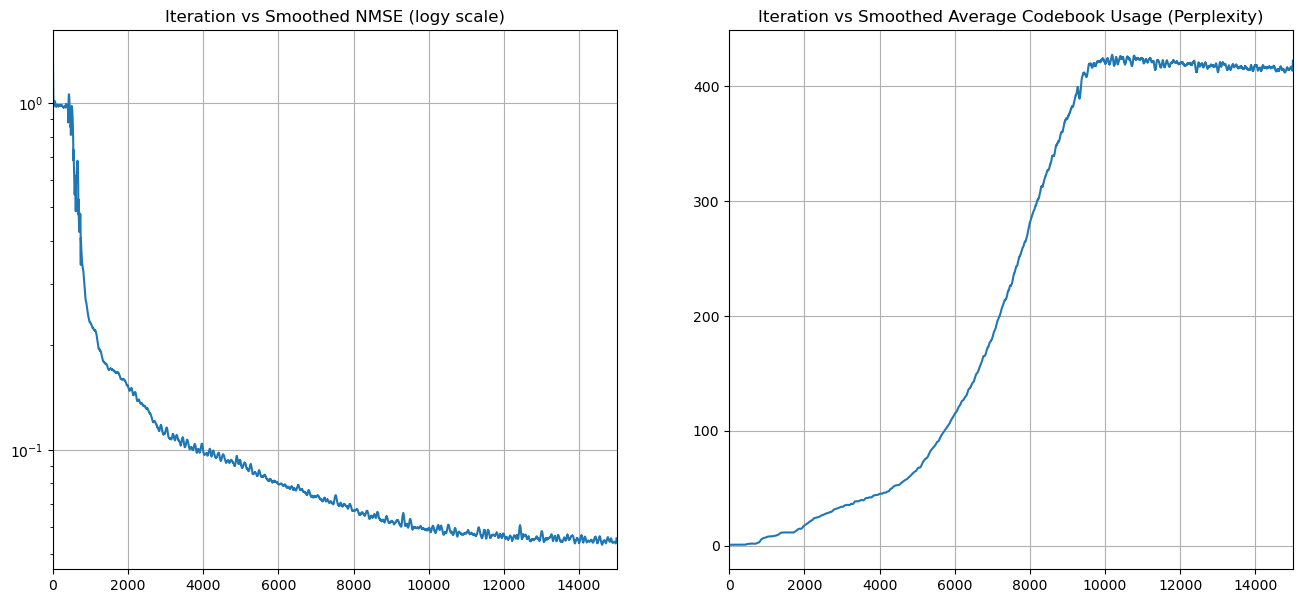

In [ ]:
f = plt.figure(figsize=(16,7))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_xlim(0, num_training_updates)
ax.set_yscale('log')
ax.set_title('Iteration vs Smoothed NMSE (logy scale)')
plt.grid()

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_xlim(0, num_training_updates)
ax.set_title('Iteration vs Smoothed Average Codebook Usage (Perplexity)')
plt.grid()
plt.show()
plt.close()

## View Reconstructions

In [ ]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(valid_originals))
_, valid_quantize, _, _ = model.vq_vae(vq_output_eval)
valid_reconstructions = model.decoder(valid_quantize)

In [ ]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model.vq_vae(train_originals)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


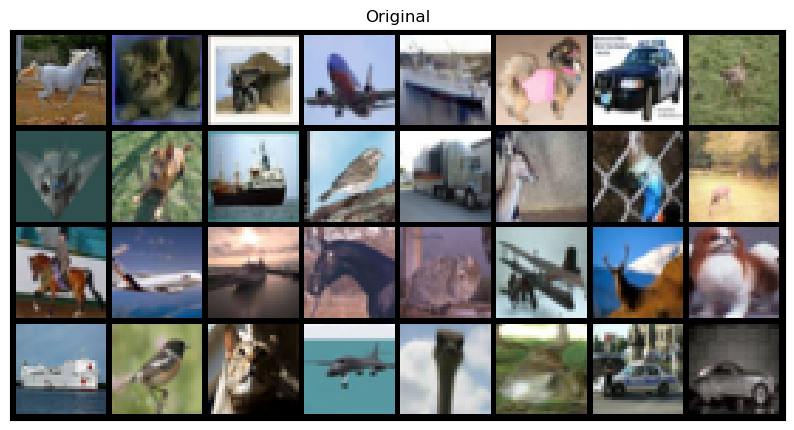

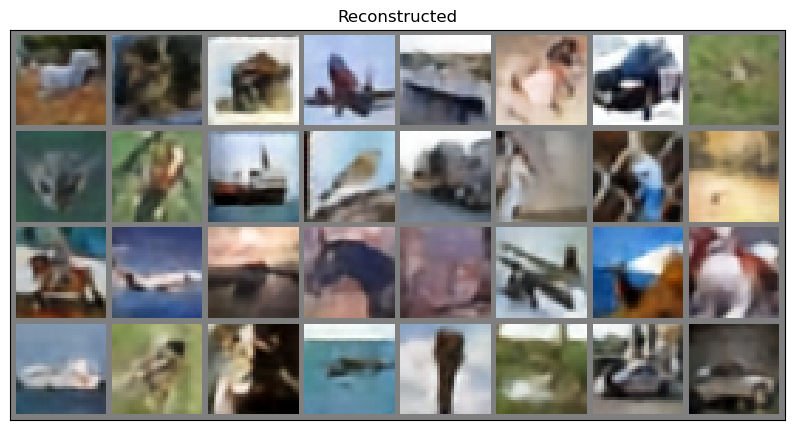

In [ ]:
def show(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(10, 8))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

show(make_grid(valid_originals.cpu() + 0.5), title='Original')
show(make_grid(valid_reconstructions.cpu().data) + 0.5, title='Reconstructed')

## View Embedding

pip install umap-learn

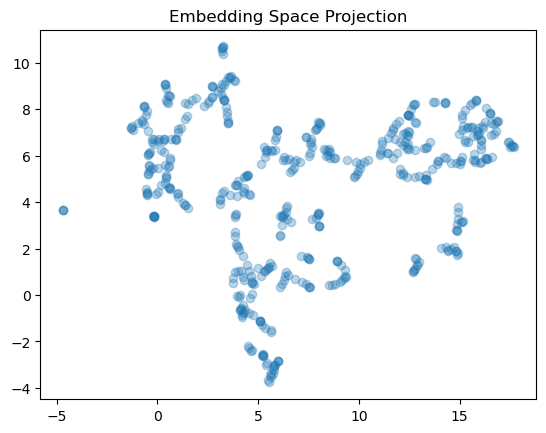

In [ ]:
proj = umap.UMAP(
    n_neighbors=3,
    min_dist=0.1,
    metric='cosine'
).fit_transform(model.vq_vae.embedding.weight.data.cpu())

plt.figure()
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)
plt.title("Embedding Space Projection")
plt.show()
plt.close()

### Random Sampling The VQ-VAE

1) **Random sampling:** Randomly selecting latent codes without regard to their spatial or distributional relationships learned during training is akin to picking puzzle pieces from different puzzles and trying to fit them together. The likelihood of generating a coherent image this way is low because the meaningful structure of the latent space is not utilized.

2) **Lack of Sequential or Spacial Context:** For datasets with complex structures like CIFAR-10, the arrangement of latent codes in a sequence that corresponds to a coherent image requires understanding the spatial or sequential relationships between codes. Random sampling does not preserve these relationships, which are critical for generating recognizable objects.

3) **Need for a Structured Approach:** To generate meaningful samples that resemble training data, one typically needs a structured approach to sampling latent codes. This could involve using an additional model trained to understand the distribution of latent codes (such as an autoregressive model) or employing techniques to navigate the latent space in a way that respects the learned organization of embeddings.

4) **Purpose of Random Sampling:** Random sampling from the embedding space is more about exploring the diversity and coverage of the learned representations rather than expecting coherent generation. It can serve as a diagnostic tool to understand the variety of features captured by the embeddings but is not a method geared towards high-quality data generation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


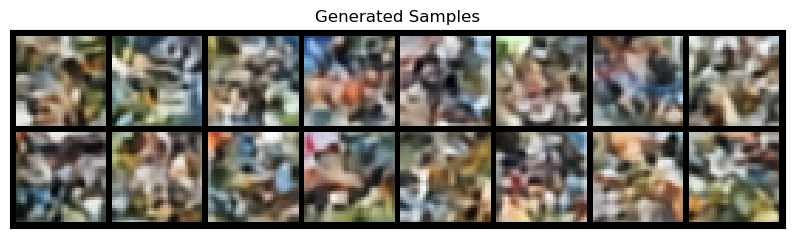

In [ ]:
def sample_vqvae():
    model.eval()
    # Generate random indices for the latent codes:
    random_indices = tc.randint(low=0, high=n_embeddings, size=(num_samples, *spatial_dims), device=device)
    with tc.no_grad():
        latent_vectors = model.vq_vae.embedding(random_indices).permute(0, 3, 1, 2)
        return model.decoder(latent_vectors)

num_samples = 16
spatial_dims = (8, 8)
generated_data = sample_vqvae()

show(make_grid(generated_data.cpu() + 0.5), title='Generated Samples')

### Expanding VQ-VAEs Further

For more advancements on VQ-VAEs, you can check out:

1) https://arxiv.org/pdf/1906.00446.pdf
"Generating Diverse High-Fidelity Images with VQ-VAE-2", which presents an improved VQ-VAE model capable of generating high-quality, diverse images. It leverages a hierarchical, multi-scale approach with powerful autoregressive priors in the latent space, outperforming traditional generative models like GANs in terms of diversity and fidelity, particularly on complex datasets like ImageNet. The model maintains simplicity in its encoder and decoder architecture, ensuring efficiency in encoding and decoding processes.

2) https://arxiv.org/pdf/2012.09841.pdf
"Taming Transformers for High-Resolution Image Synthesis", that introduces a method that leverages the power of transformers, combined with a novel VQ-VAE, to generate high-resolution images. By addressing the transformers' limitations in handling large-scale image data directly, this approach efficiently synthesizes detailed and coherent images across diverse datasets. It showcases improved scalability and quality in image generation tasks, making a significant advancement in the field of generative models.